<a href="https://colab.research.google.com/github/Amaljith33/EPL_young_players_Stats/blob/main/EPL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load a Excel file from Google Drive
drive.mount('/content/drive')
#File paths
file_path_1 = '/content/drive/My Drive/Standards.xlsx'
file_path_2 = '/content/drive/My Drive/Gk.xlsx'
file_path_3 = '/content/drive/My Drive/AdvGk.xlsx'
file_path_4 = '/content/drive/My Drive/Shooting.xlsx'
file_path_5 = '/content/drive/My Drive/Passing.xlsx'
file_path_6 = '/content/drive/My Drive/Def Action.xlsx'
file_path_7 = '/content/drive/My Drive/Possession.xlsx'
file_path_8 = '/content/drive/My Drive/Miscellaneous.xlsx'

#Datasets
Standards = pd.read_excel(file_path_1)
GK = pd.read_excel(file_path_2)
Adv_GK = pd.read_excel(file_path_3)
Shooting = pd.read_excel(file_path_4)
Passing = pd.read_excel(file_path_5)
Def_Action = pd.read_excel(file_path_6)
Possession = pd.read_excel(file_path_7)
Miscellaneous = pd.read_excel(file_path_8)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Removing unwanted columns
columns_to_remove = ['Rk', 'Nation', 'Pos', 'Squad', 'Age', 'Born', 'Matches',
                     '90s']
Shooting = Shooting.drop(columns=columns_to_remove, errors='ignore')
Passing = Passing.drop(columns=columns_to_remove, errors='ignore')
Def_Action = Def_Action.drop(columns=columns_to_remove, errors='ignore')
Possession = Possession.drop(columns=columns_to_remove, errors='ignore')
Miscellaneous = Miscellaneous.drop(columns=columns_to_remove, errors='ignore')

ctr = ['Rk', 'G-PK', 'PK', 'PKatt', 'npxG', 'PrgC', 'PrgP', 'PrgR', 'Gls2',
       'Ast3', 'G+A4', 'G-PK5', 'G+A-PK','xG6', 'xAG7', 'npxG8', 'npxG+xAG9']
ctr_1 = ['SoT%', 'Sh/90', 'SoT/90', 'G/Sh', 'Dist', 'FK', 'PK', 'PKatt', 'npxG',
         'npxG/Sh', 'G-xG', 'np:G-xG']
ctr_2 = ['TotDist', 'PrgDist', 'Cmp2', 'Att3', 'Cmp%4',
                             'Cmp5', 'Att6', 'Cmp%7', 'Cmp8', 'Att9', 'Cmp%10',
                             'xAG', 'xA', 'A-xAG']
ctr_3 = ['Tkl2', 'Att', 'Tkl%', 'Lost', 'Blocks', 'Sh', 'Pass']
ctr_4 = ['Def 3rd', 'Mid 3rd', 'Att 3rd',' Att Pen', 'Live', 'Att', 'Succ%',
         'Tkld', 'Tkld%', 'TotDist', 'PrgDist', 'PrgC', '1/3', 'CPA', 'Rec',
         'PrgR']
ctr_5 = ['CrdY', 'CrdR', 'TklW', 'Won%']

Standards = Standards.drop(columns= ctr, errors= 'ignore')
Passing = Passing.drop(columns=ctr_1, errors='ignore')
Shooting = Shooting.drop(columns=ctr_2, errors='ignore')
Def_Action = Def_Action.drop(columns= ctr_3, errors= 'ignore')
Possession = Possession.drop(columns = ctr_4, errors= 'ignore' )
Miscellaneous = Miscellaneous.drop(columns = ctr_5, errors = 'ignore')

In [ ]:
#Merging dataset
datasets = [Shooting, Passing, Def_Action, Possession, Miscellaneous]
Out_fld_plyr = Standards
for dataset in datasets:
    Out_fld_plyr = pd.merge(Out_fld_plyr, dataset, on='Player', how='inner')
Out_fld_plyr = Out_fld_plyr.drop_duplicates(subset=['Player'])

Goalkeeper = pd.merge(GK, Adv_GK, on='Player', how='inner')

ctr_6 = ['npxG+xAG', 'Gls_y', 'xG_y', 'npxG', 'npxG/Sh', 'np:G-xG', 'Ast_y',
         'Int_y']
Out_fld_plyr = Out_fld_plyr.drop(columns = ctr_6, errors = 'ignore')
Out_fld_plyr = Out_fld_plyr[Out_fld_plyr['Pos'] != 'GK']
Out_fld_plyr = Out_fld_plyr.fillna(0)

In [ ]:
Out_fld_plyr_u25 = Out_fld_plyr[Out_fld_plyr['Age'] < 26]
GK_u25 = Goalkeeper[Goalkeeper['Age_x'] < 26]
#Taking usefull features for both outfield players and goalkeepers
features_to_keep_ofp = [
    'Player', 'Age', 'Pos', '90s', 'Gls_x', 'Ast_x', 'xG_x', 'xAG_x', 'Sh',
    'SoT', 'SoT%', 'G/Sh', 'G/SoT', 'KP', 'Tkl', 'TklW', 'Int_x', 'Clr',
    'Err', 'TotDist', 'PrgDist', 'Carries', 'Touches', 'Recov', 'Fls', 'CrdY',
    'CrdR', 'Won', 'Lost'
]

features_to_keep_gk = [
    'Player', 'Age_x', '90s_x', 'GA_x', 'GA90', 'Saves', 'Save%',
    'SoTA', 'CS', 'CS%', 'PSxG', 'PSxG/SoT', 'PSxG+/-', 'Saves', 'Save%',
    'PKatt', 'PKsv', 'Cmp', 'Att', 'Cmp%', 'Opp', 'Stp', '#OPA', '#OPA/90'
]
Out_fld_plyr_u25_selected = Out_fld_plyr_u25[features_to_keep_ofp]
GK_U25_selected = GK_u25[features_to_keep_gk]
GK_U25_selected

,Player,Age_x,90s_x,GA_x,GA90,Saves,Save%,SoTA,CS,CS%,...,Save%,PKatt,PKsv,Cmp,Att,Cmp%,Opp,Stp,#OPA,#OPA/90
13,Caoimhín Kelleher,24,10.0,11,1.10,28,71.1,38,2,20.0,...,71.1,0,0,32,102,31.4,77,5,13,1.30
17,Arijanet Muric,24,10.0,16,1.60,62,80.8,78,0,0.0,...,80.8,2,1,77,219,35.2,143,20,31,3.10
22,Đorđe Petrović,23,22.1,38,1.72,73,65.7,108,5,22.7,...,65.7,2,0,67,214,31.3,312,20,20,0.91
26,Aaron Ramsdale,25,6.0,5,0.83,9,64.3,14,2,33.3,...,64.3,0,0,19,69,27.5,46,8,9,1.50
29,Robert Sánchez,25,15.9,25,1.57,52,70.5,78,3,18.8,...,70.5,3,1,61,147,41.5,202,19,27,1.70
34,James Trafford,20,28.0,62,2.21,106,65.7,166,2,7.1,...,65.7,5,0,138,606,22.8,419,30,43,1.54
35,Mark Travers,24,4.0,5,1.25,13,77.8,18,2,50.0,...,77.8,1,0,22,72,30.6,60,3,3,0.75
37,Bart Verbruggen,20,21.0,28,1.33,63,72.5,91,4,19.0,...,72.5,3,0,55,142,38.7,232,17,31,1.48


In [ ]:
numeric_columns = ['Gls_x', 'Ast_x', '90s', 'Won', 'Lost', 'SoT', 'Sh']
Out_fld_plyr_u25_selected[numeric_columns] = Out_fld_plyr_u25_selected[numeric_columns].apply(pd.to_numeric,
                                                                                              errors='coerce')
GK_U25_selected = GK_U25_selected.loc[:,~GK_U25_selected.columns.duplicated()]

for col in ['Saves', '90s_x', 'GA_x', 'CS', 'SoTA', 'PKsv', 'PKatt',
            'Cmp', 'Att']:
    if col in GK_U25_selected.columns:
     GK_U25_selected.fillna(0, inplace=True)

<ipython-input-5-e5a77ee50301>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Out_fld_plyr_u25_selected[numeric_columns] = Out_fld_plyr_u25_selected[numeric_columns].apply(pd.to_numeric,
<ipython-input-5-e5a77ee50301>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GK_U25_selected.fillna(0, inplace=True)


In [ ]:
#New features
#Outfield players
Out_fld_plyr_u25_selected['Goals_per_90'] = Out_fld_plyr_u25_selected['Gls_x'] /  Out_fld_plyr_u25_selected['90s']
Out_fld_plyr_u25_selected['Assists_per_90'] = Out_fld_plyr_u25_selected['Ast_x'] / Out_fld_plyr_u25_selected['90s']
Out_fld_plyr_u25_selected['Shot_Accuracy'] = Out_fld_plyr_u25_selected['SoT'] / Out_fld_plyr_u25_selected['Sh']
Out_fld_plyr_u25_selected['xG_per_90'] = Out_fld_plyr_u25_selected['xG_x'] /  Out_fld_plyr_u25_selected['90s']
Out_fld_plyr_u25_selected['xAG_per_90'] = Out_fld_plyr_u25_selected['xAG_x'] / Out_fld_plyr_u25_selected['90s']
Out_fld_plyr_u25_selected['Defensive_Actions'] = Out_fld_plyr_u25_selected['Tkl'] + Out_fld_plyr_u25_selected['Int_x'] + Out_fld_plyr_u25_selected['Clr']
Out_fld_plyr_u25_selected['PrgDist_per_90'] = Out_fld_plyr_u25_selected['PrgDist'] / Out_fld_plyr_u25_selected['90s']
Out_fld_plyr_u25_selected['Recoveries_per_90'] = Out_fld_plyr_u25_selected['Recov'] / Out_fld_plyr_u25_selected['90s']
Out_fld_plyr_u25_selected['Card_Discipline'] = Out_fld_plyr_u25_selected['CrdY'] + 2 * Out_fld_plyr_u25_selected['CrdR']
Out_fld_plyr_u25_selected['Aerials_per_90'] = (Out_fld_plyr_u25_selected['Won'] + Out_fld_plyr_u25_selected['Lost']) / Out_fld_plyr_u25_selected['90s']
Out_fld_plyr_u25_selected['KP_per_90'] = Out_fld_plyr_u25_selected['KP'] / Out_fld_plyr_u25_selected['90s']

#Goalkeepers
GK_U25_selected['Save_Impact'] = GK_U25_selected['PSxG'] - GK_U25_selected['GA_x']
GK_U25_selected['Saves_per_90'] = GK_U25_selected['Saves'] / GK_U25_selected['90s_x']
GK_U25_selected['Goals_Against_per_90'] = GK_U25_selected['GA_x'] / GK_U25_selected['90s_x']
GK_U25_selected['Clean_Sheets_per_90'] = GK_U25_selected['CS'] / GK_U25_selected['90s_x']
GK_U25_selected['Effective_Save%'] = (GK_U25_selected['Saves'] / GK_U25_selected['SoTA']) * 100
GK_U25_selected['Penalty_Save%'] = (GK_U25_selected['PKsv'] / GK_U25_selected['PKatt']) * 100
GK_U25_selected['Cmp_per_90'] = GK_U25_selected['Cmp'] /GK_U25_selected['90s_x']
GK_U25_selected['Att_per_90'] = GK_U25_selected['Att'] /GK_U25_selected['90s_x']
GK_U25_selected['Distribution_Accuracy'] = (GK_U25_selected['Cmp'] / GK_U25_selected['Att']) * 100
GK_U25_selected['Total_Goalkeeping_Impact'] = (GK_U25_selected['Saves'] * 0.5) + (GK_U25_selected['CS'] * 0.3) - (GK_U25_selected['GA_x'] * 0.2)
GK_U25_selected['Consistency_Index'] = GK_U25_selected['Saves'] / (GK_U25_selected['GA_x'] + 1)

<ipython-input-6-dfbc035354a9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Out_fld_plyr_u25_selected['Goals_per_90'] = Out_fld_plyr_u25_selected['Gls_x'] /  Out_fld_plyr_u25_selected['90s']
<ipython-input-6-dfbc035354a9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Out_fld_plyr_u25_selected['Assists_per_90'] = Out_fld_plyr_u25_selected['Ast_x'] / Out_fld_plyr_u25_selected['90s']
<ipython-input-6-dfbc035354a9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [ ]:
#Making new table with new features
new_features_ofp = [
    'Player', 'Age', 'Goals_per_90', 'Assists_per_90', 'Shot_Accuracy',
    'xG_per_90', 'xAG_per_90', 'Defensive_Actions', 'PrgDist_per_90',
    'Recoveries_per_90', 'Card_Discipline', 'Aerials_per_90', 'KP_per_90'
]
U25_Out_fld_plyr = Out_fld_plyr_u25_selected[new_features_ofp]

new_features_gk = ['Player', 'Age_x', 'Save_Impact', 'Saves_per_90',
                'Goals_Against_per_90','Clean_Sheets_per_90', 'Effective_Save%',
                'Penalty_Save%', 'Cmp_per_90', 'Att_per_90',
                'Distribution_Accuracy','Total_Goalkeeping_Impact',
                'Consistency_Index']
U25_GK = GK_U25_selected[new_features_gk]

# Fill NaN values with 0 in the U23_Out_fld_plyr DataFrame
U25_Out_fld_plyr.fillna(0, inplace=True)

U25_Out_fld_plyr.to_excel('/content/drive/My Drive/U23_Out_fld_plyr.xlsx',
                         index=False)
U25_GK.to_excel('/content/drive/My Drive/U23_GK.xlsx',
                         index=False)

<ipython-input-7-ffbae465413c>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  U25_Out_fld_plyr.fillna(0, inplace=True)


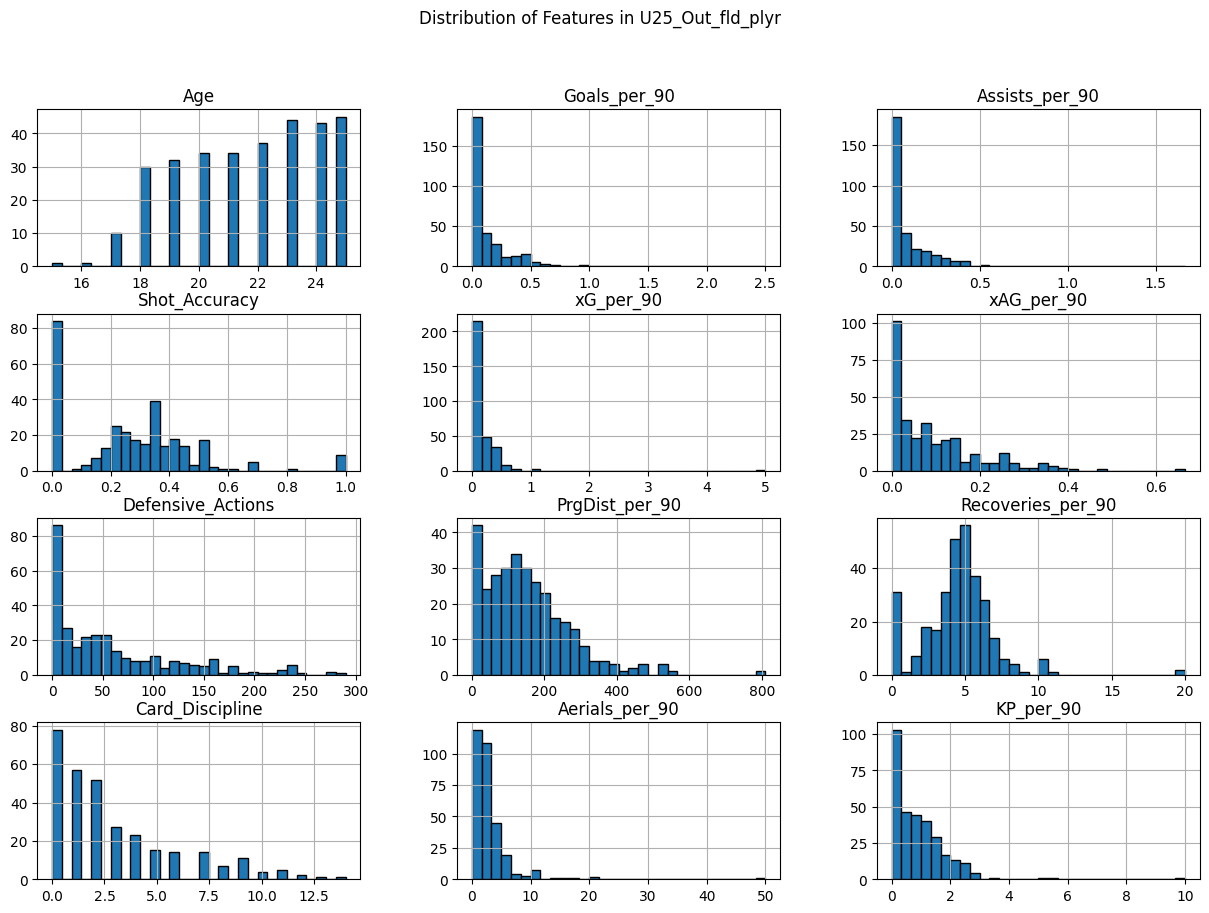

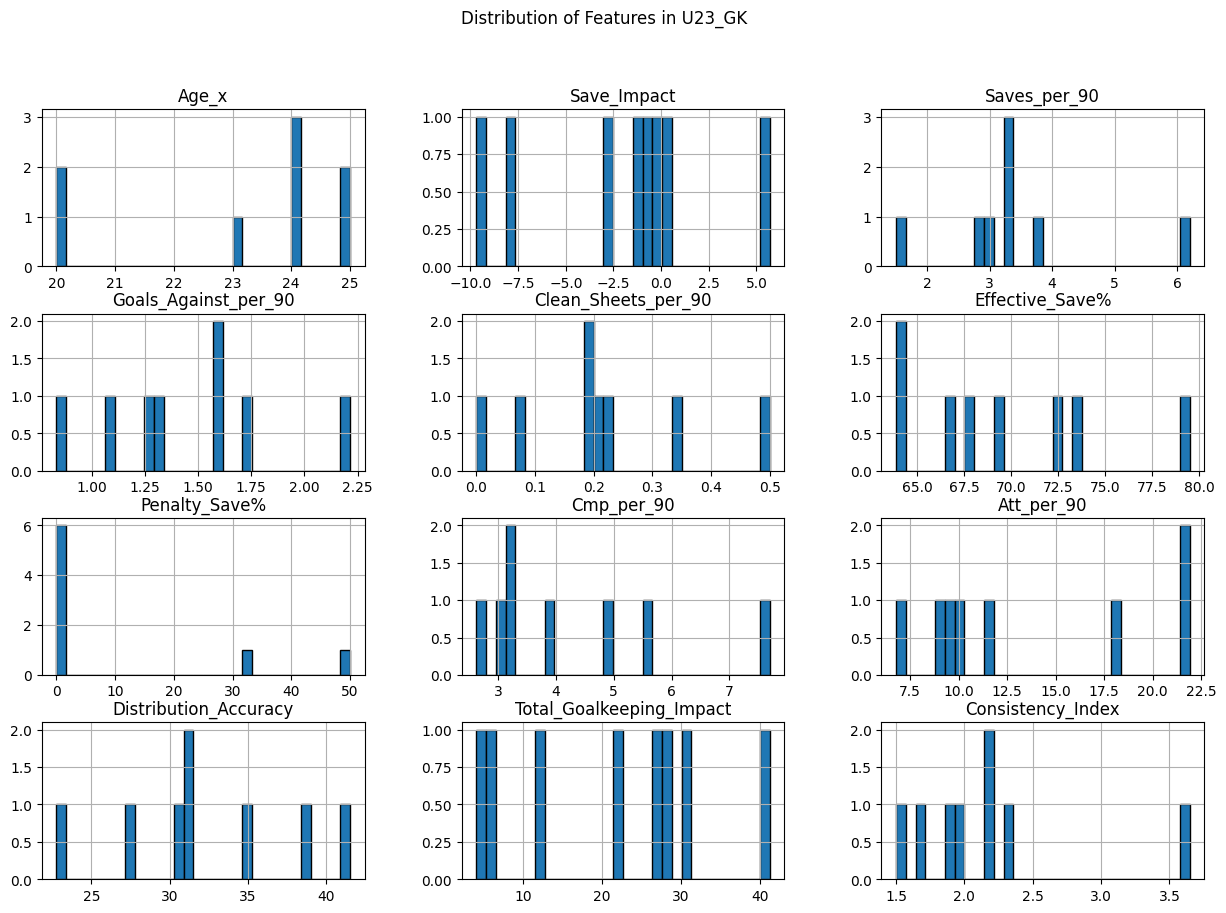

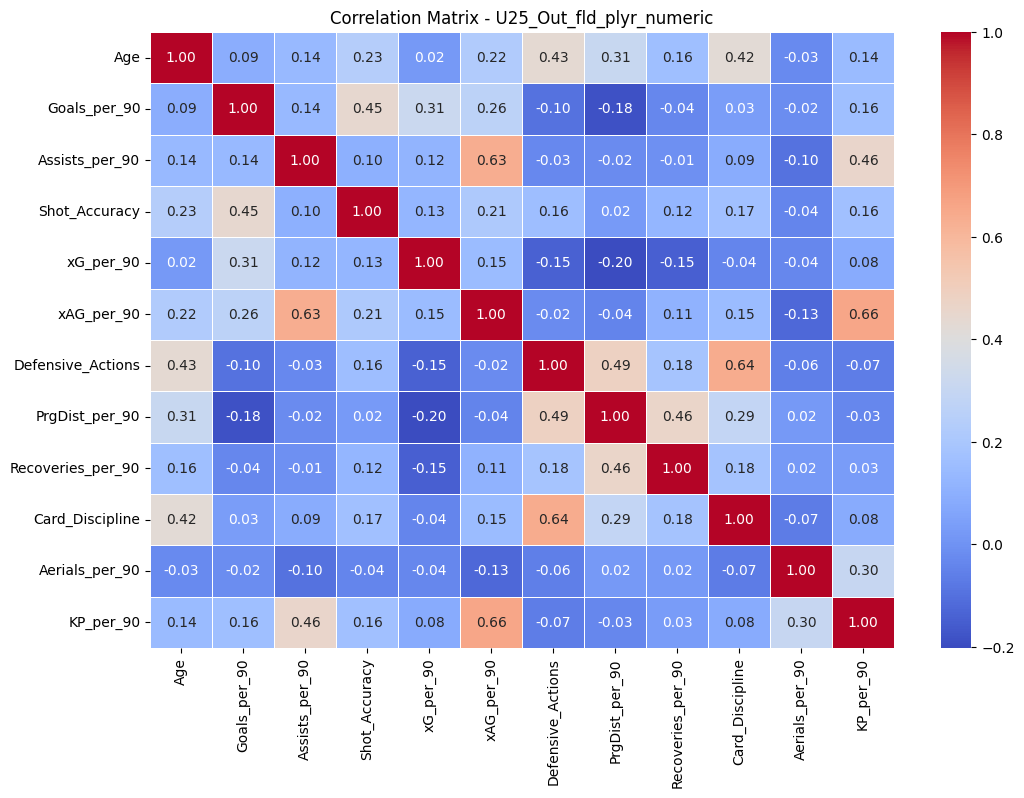

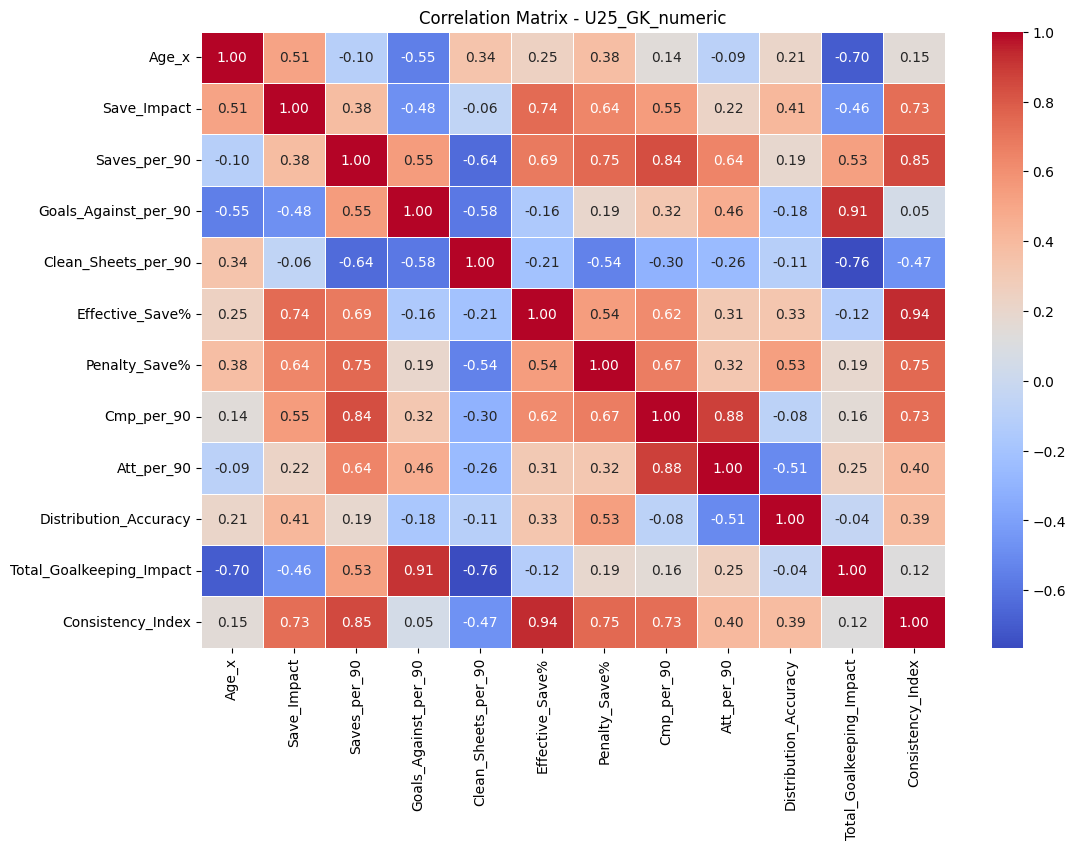

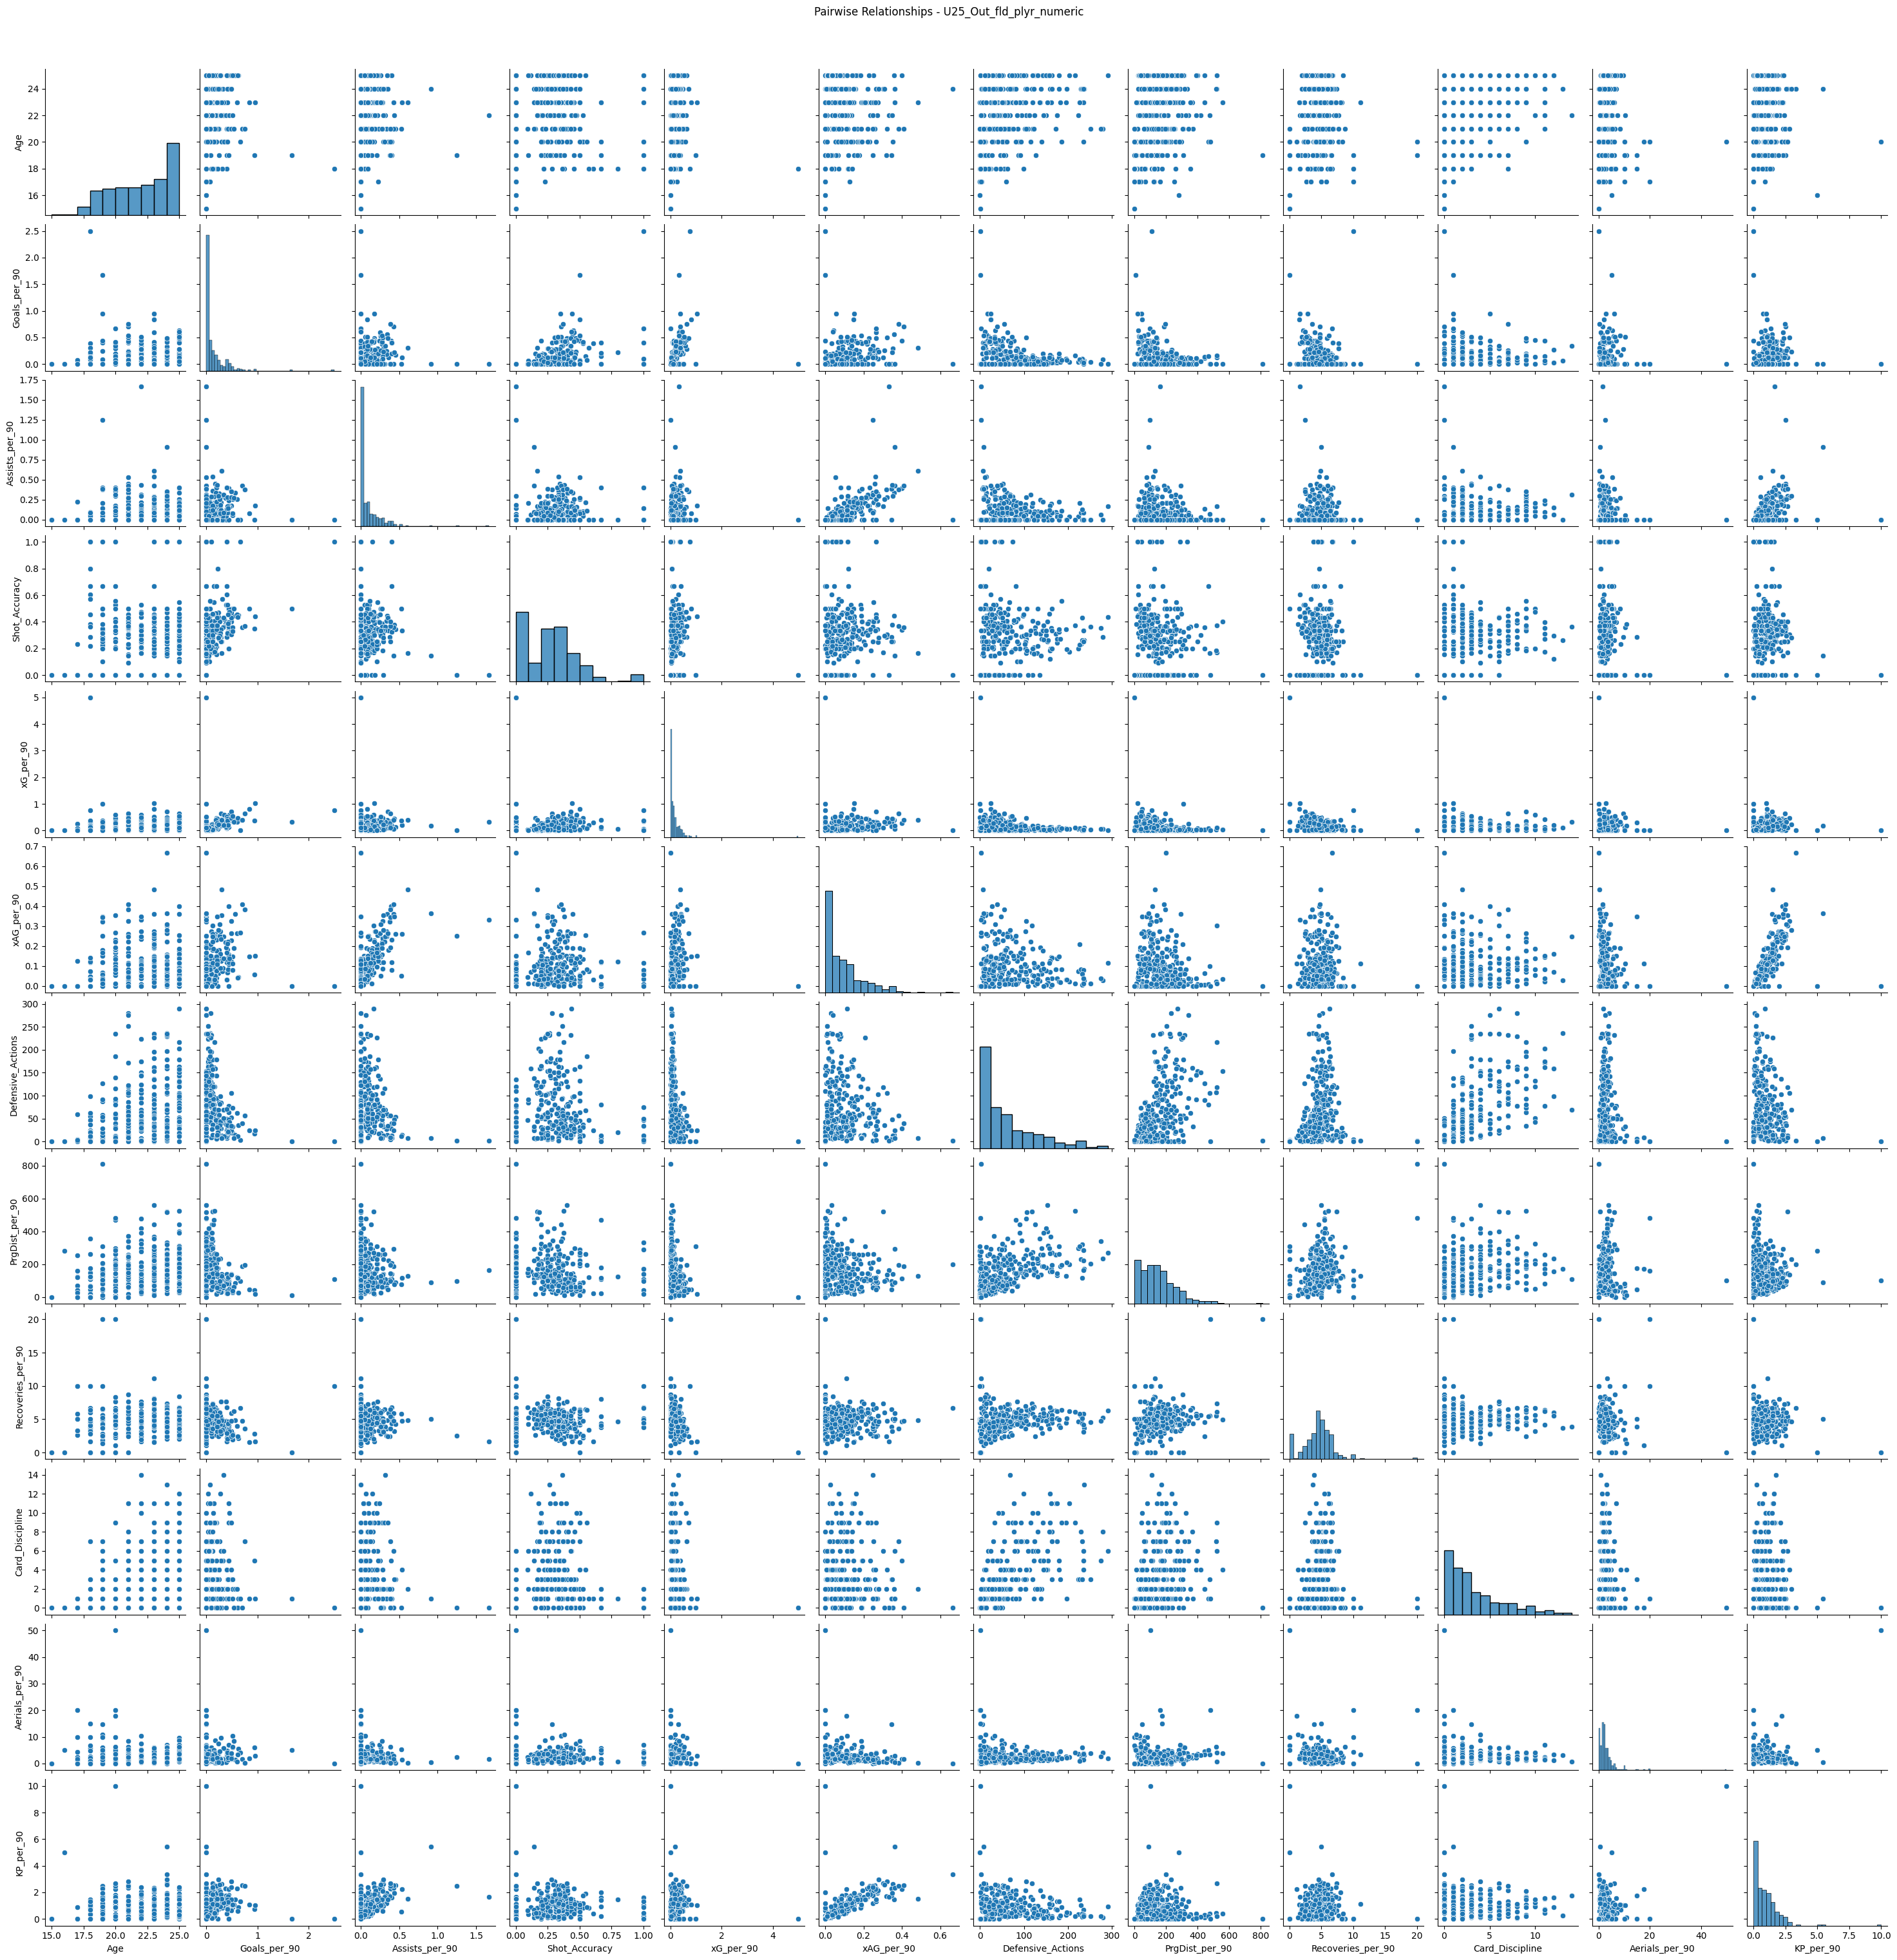

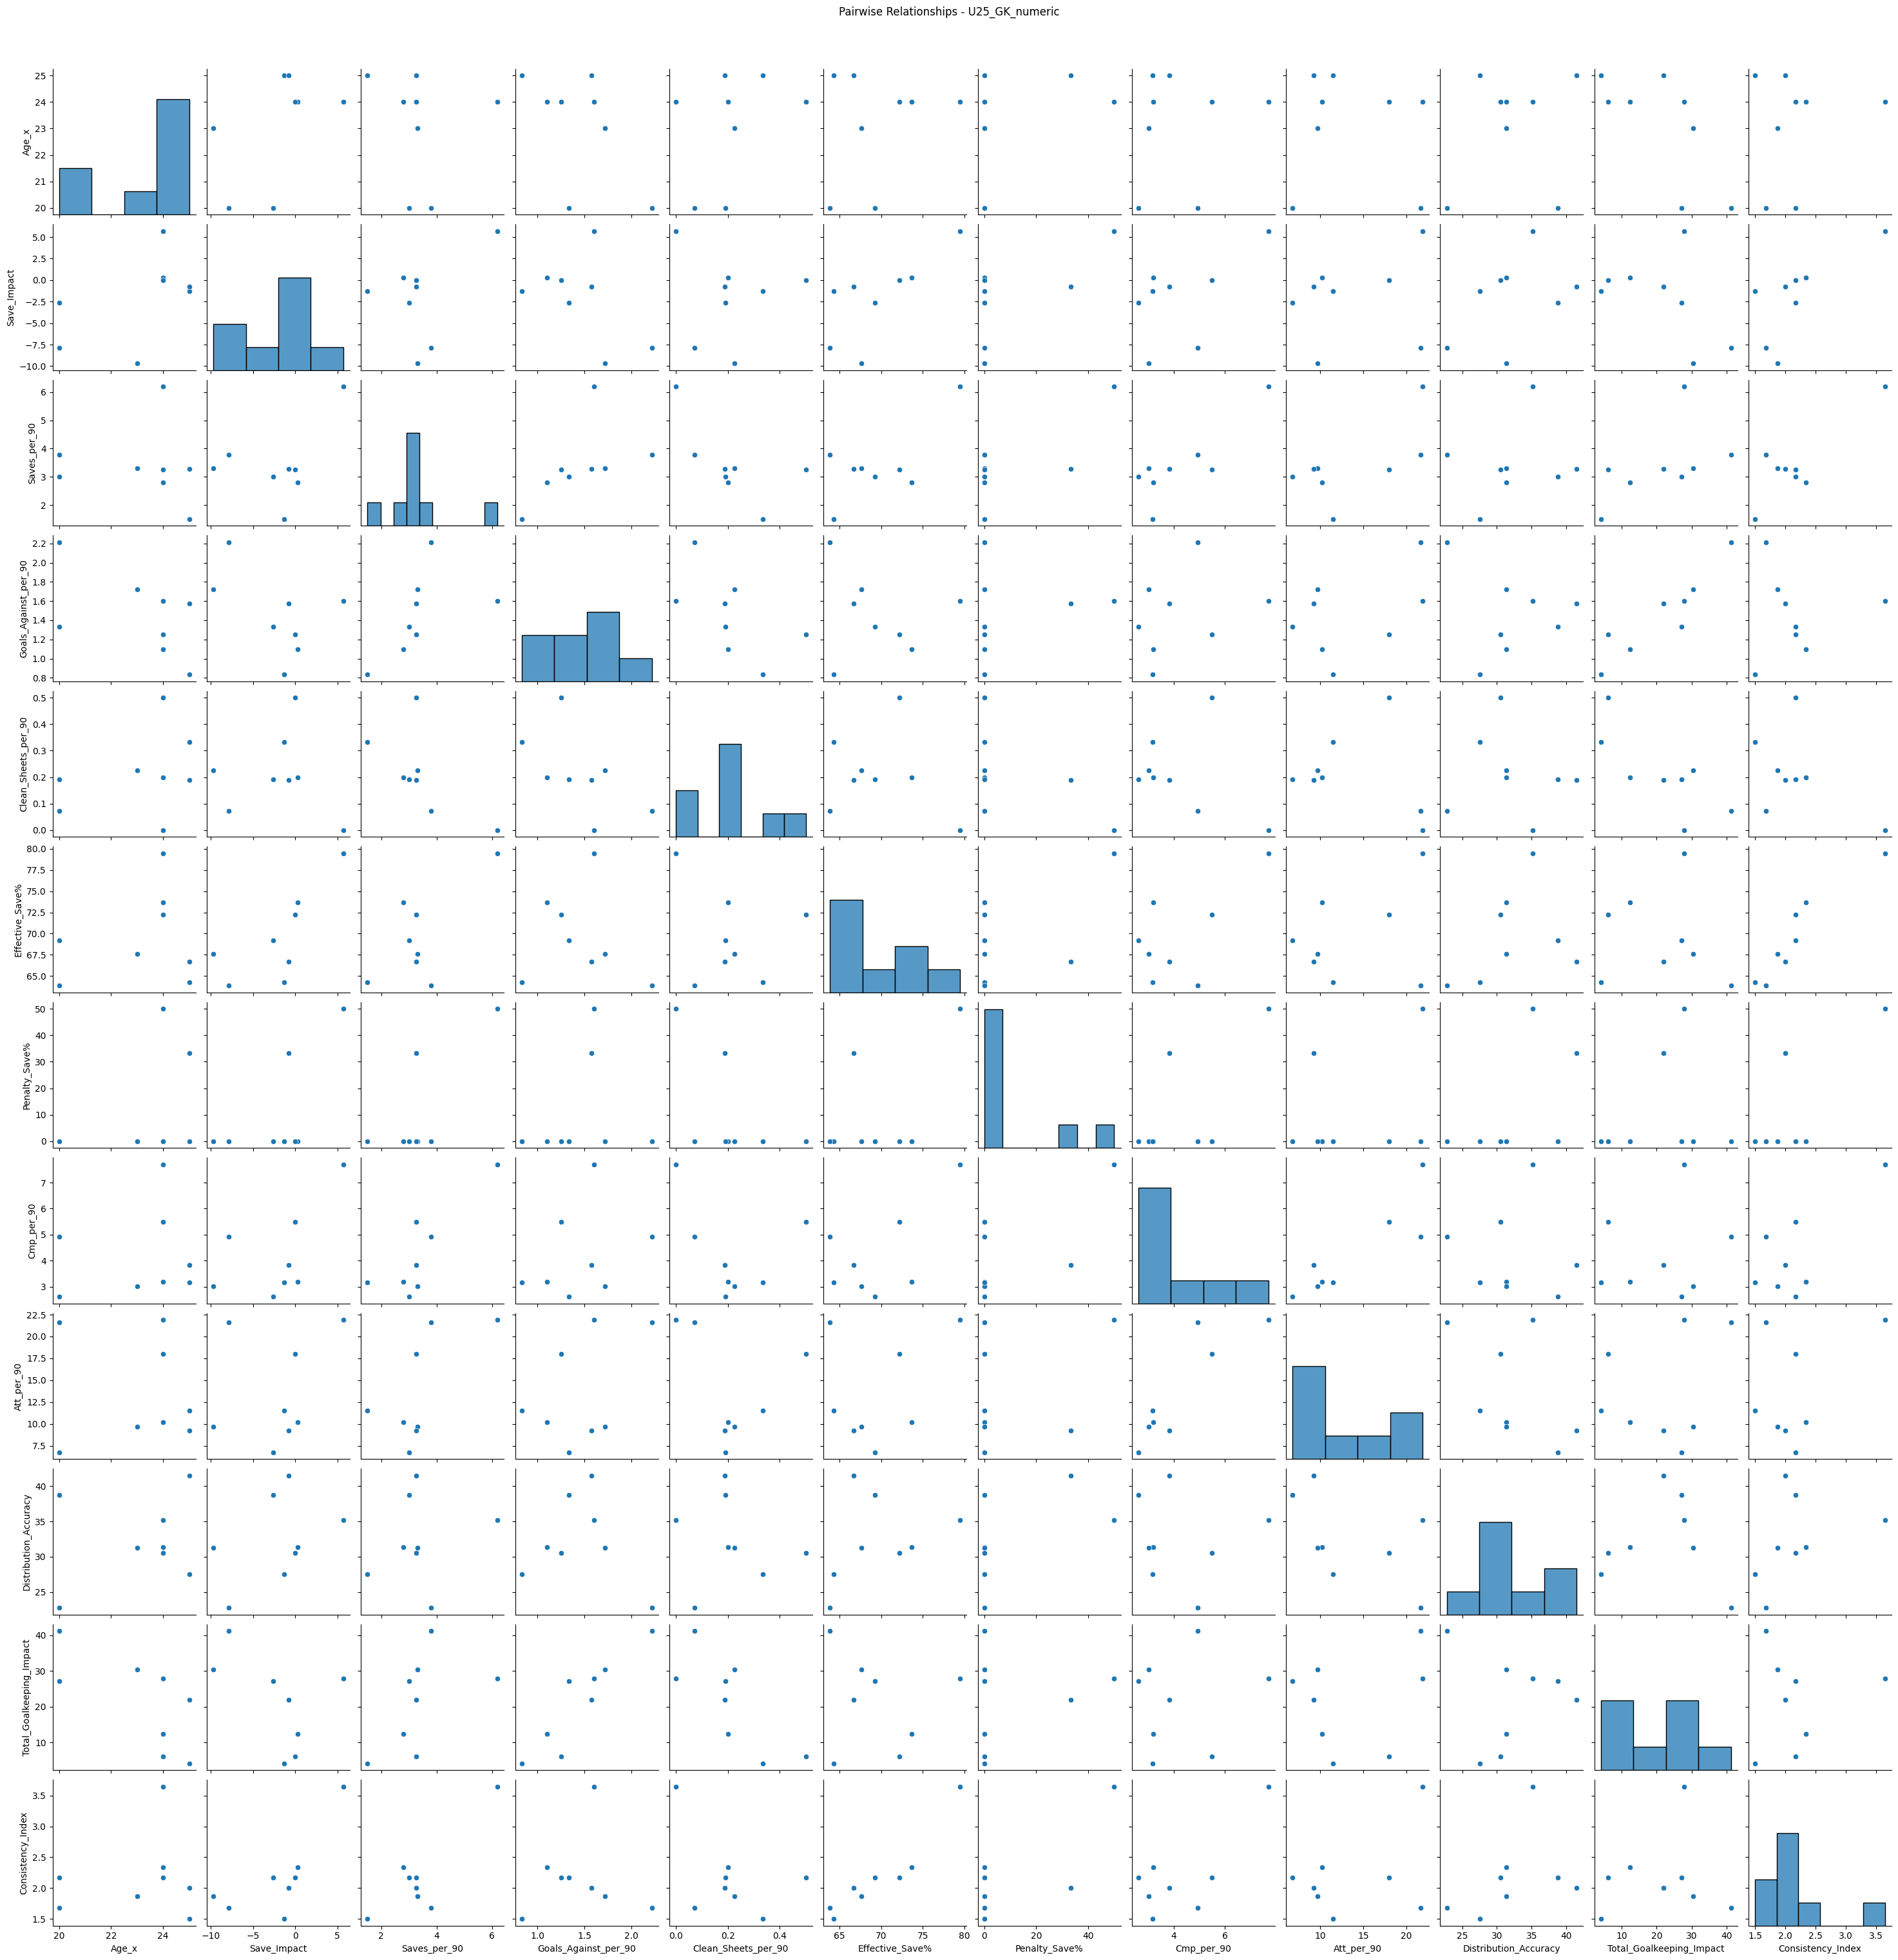

In [ ]:
# Setup for saving plots to Google Drive
drive_path = '/content/drive/My Drive/plots/'
if not os.path.exists(drive_path):
    os.makedirs(drive_path)

# Select numeric columns from U25_Out_fld_plyr
U25_Out_fld_plyr_numeric = U25_Out_fld_plyr.select_dtypes(include=[np.number])

# Select numeric columns from U25_GK
U25_GK_numeric = U25_GK.select_dtypes(include=[np.number])

# Handle infinite and NaN values if necessary
U25_Out_fld_plyr_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)
U25_Out_fld_plyr_numeric.fillna(0, inplace=True)

U25_GK_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)
U25_GK_numeric.fillna(0, inplace=True)

# Histograms for U25_Out_fld_plyr_numeric
U25_Out_fld_plyr_numeric.hist(figsize=(15, 10), bins=30, edgecolor='black')
plt.suptitle('Distribution of Features in U25_Out_fld_plyr')
plt.savefig(drive_path + 'U25_Out_fld_plyr_histograms.png')
plt.show()

# Histograms for U25_GK_numeric
U25_GK_numeric.hist(figsize=(15, 10), bins=30, edgecolor='black')
plt.suptitle('Distribution of Features in U23_GK')
plt.savefig(drive_path + 'U25_GK_histograms.png')
plt.show()
# Correlation matrix for U25_Out_fld_plyr_numeric
plt.figure(figsize=(12, 8))
sns.heatmap(U25_Out_fld_plyr_numeric.corr(), annot=True, cmap='coolwarm',
            fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix - U25_Out_fld_plyr_numeric')
plt.savefig(drive_path + 'U25_Out_fld_plyr_correlation_matrix.png')
plt.show()

# Correlation matrix for U25_GK_numeric
plt.figure(figsize=(12, 8))
sns.heatmap(U25_GK_numeric.corr(), annot=True, cmap='coolwarm',
            fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix - U25_GK_numeric')
plt.savefig(drive_path + 'U25_GK_correlation_matrix.png')
plt.show()
# Pairplot for U25_Out_fld_plyr_numeric
sns.pairplot(U25_Out_fld_plyr_numeric)
plt.suptitle('Pairwise Relationships - U25_Out_fld_plyr_numeric', y=1.02)
plt.savefig(drive_path + 'U25_Out_fld_plyr_pairplot.png')
plt.show()

# Pairplot for U25_GK_numeric
sns.pairplot(U25_GK_numeric)
plt.suptitle('Pairwise Relationships - U25_GK_numeric', y=1.02)
plt.savefig(drive_path +'U25_GK_pairplot.png')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Replace infinite values and fill NaNs with 0
U25_Out_fld_plyr.replace([np.inf, -np.inf], np.nan, inplace=True)
U25_Out_fld_plyr.fillna(0, inplace=True)

U25_GK.replace([np.inf, -np.inf], np.nan, inplace=True)
U25_GK.fillna(0, inplace=True)

# Define the features and the targets for outfield players
features_outfield = U25_Out_fld_plyr.drop(columns=['Player', 'Goals_per_90',
                    'Assists_per_90', 'Shot_Accuracy', 'xG_per_90', 'xAG_per_90',
                    'Defensive_Actions', 'PrgDist_per_90', 'Recoveries_per_90',
                    'Card_Discipline', 'Aerials_per_90', 'KP_per_90'])

targets_outfield = U25_Out_fld_plyr[['Goals_per_90', 'Assists_per_90', 'Shot_Accuracy',
    'xG_per_90', 'xAG_per_90', 'Defensive_Actions', 'PrgDist_per_90',
    'Recoveries_per_90', 'Card_Discipline', 'Aerials_per_90', 'KP_per_90']]

# Define features and targets for goalkeepers
features_gk = U25_GK.drop(columns=['Player', 'Save_Impact', 'Saves_per_90',
                'Goals_Against_per_90','Clean_Sheets_per_90', 'Effective_Save%',
                'Penalty_Save%', 'Cmp_per_90', 'Att_per_90',
                'Distribution_Accuracy','Total_Goalkeeping_Impact',
                'Consistency_Index'])

targets_gk = U25_GK[['Save_Impact', 'Saves_per_90',
                'Goals_Against_per_90','Clean_Sheets_per_90', 'Effective_Save%',
                'Penalty_Save%', 'Cmp_per_90', 'Att_per_90',
                'Distribution_Accuracy','Total_Goalkeeping_Impact',
                'Consistency_Index']]

# Split the data into training and testing sets for outfield players
X_train_outfield, X_test_outfield, y_train_outfield, y_test_outfield = train_test_split(
    features_outfield, targets_outfield, test_size=0.2, random_state=42)

# Standardize the features
scaler_outfield = StandardScaler()
X_train_outfield = scaler_outfield.fit_transform(X_train_outfield)
X_test_outfield = scaler_outfield.transform(X_test_outfield)

# Hyperparameter tuning for outfield model using RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 300, 500, 1000],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

random_search_outfield = RandomizedSearchCV(RandomForestRegressor(random_state=42),
                                            param_distributions=param_dist,
                                            n_iter=10, cv=3, verbose=2, n_jobs=-1, random_state=42)
multi_rf_model_outfield = MultiOutputRegressor(random_search_outfield)
multi_rf_model_outfield.fit(X_train_outfield, y_train_outfield)

# Make predictions
y_pred_outfield = multi_rf_model_outfield.predict(X_test_outfield)

# Evaluate the model for each target
mae_outfield = mean_absolute_error(y_test_outfield, y_pred_outfield, multioutput='raw_values')
r2_outfield = r2_score(y_test_outfield, y_pred_outfield, multioutput='raw_values')

# Print MAE and R2 for each target variable
for i, column in enumerate(targets_outfield.columns):
    print(f'{column} - MAE: {mae_outfield[i]}, R2: {r2_outfield[i]}')

# Predict the performance for the entire dataset (next season)
U25_Out_fld_plyr[['Predicted_Goals_per_90', 'Predicted_Assists_per_90', 'Predicted_Shot_Accuracy',
    'Predicted_xG_per_90', 'Predicted_xAG_per_90', 'Predicted_Defensive_Actions', 'Predicted_PrgDist_per_90',
    'Predicted_Recoveries_per_90', 'Predicted_Card_Discipline', 'Predicted_Aerials_per_90', 'Predicted_KP_per_90']] = multi_rf_model_outfield.predict(scaler_outfield.transform(features_outfield))

RF_final_ofp = ['Player', 'Age', 'Predicted_Goals_per_90', 'Predicted_Assists_per_90', 'Predicted_Shot_Accuracy',
    'Predicted_xG_per_90', 'Predicted_xAG_per_90', 'Predicted_Defensive_Actions', 'Predicted_PrgDist_per_90',
    'Predicted_Recoveries_per_90', 'Predicted_Card_Discipline', 'Predicted_Aerials_per_90', 'Predicted_KP_per_90']
RF_pred_ofp = U25_Out_fld_plyr[RF_final_ofp]
# Save the predictions to Excel
RF_pred_ofp.to_excel('/content/drive/My Drive/U23_Outfield_Predictions_All_Targets.xlsx', index=False)


# Split the data into training and testing sets for goalkeepers
X_train_gk, X_test_gk, y_train_gk, y_test_gk = train_test_split(
    features_gk, targets_gk, test_size=0.2, random_state=42)

# Standardize the features
scaler_gk = StandardScaler()
X_train_gk = scaler_gk.fit_transform(X_train_gk)
X_test_gk = scaler_gk.transform(X_test_gk)

# Hyperparameter tuning for goalkeeper model using RandomizedSearchCV
random_search_gk = RandomizedSearchCV(RandomForestRegressor(random_state=42),
                                      param_distributions=param_dist,
                                      n_iter=10, cv=3, verbose=2, n_jobs=-1, random_state=42)
multi_rf_model_gk = MultiOutputRegressor(random_search_gk)
multi_rf_model_gk.fit(X_train_gk, y_train_gk)

# Make predictions
y_pred_gk = multi_rf_model_gk.predict(X_test_gk)

# Evaluate the model for each target
mae_gk = mean_absolute_error(y_test_gk, y_pred_gk, multioutput='raw_values')
r2_gk = r2_score(y_test_gk, y_pred_gk, multioutput='raw_values')

# Print MAE and R2 for each target variable
for i, column in enumerate(targets_gk.columns):
    print(f'{column} - MAE: {mae_gk[i]}, R2: {r2_gk[i]}')

# Predict the performance for the entire dataset (next season)
U25_GK[['Predicted_Save_Impact', 'Predicted_Saves_per_90',
        'Predicted_Goals_Against_per_90', 'Predicted_Clean_Sheets_per_90',
        'Predicted_Effective_Save%', 'Predicted_Penalty_Save%',
        'Predicted_Cmp_per_90', 'Predicted_Att_per_90',
        'Predicted_Distribution_Accuracy', 'Predicted_Total_Goalkeeping_Impact',
        'Predicted_Consistency_Index']] = multi_rf_model_gk.predict(scaler_gk.transform(features_gk))

RF_final_GK = ['Player', 'Age_x', 'Predicted_Save_Impact', 'Predicted_Saves_per_90',
        'Predicted_Goals_Against_per_90', 'Predicted_Clean_Sheets_per_90',
        'Predicted_Effective_Save%', 'Predicted_Penalty_Save%',
        'Predicted_Cmp_per_90', 'Predicted_Att_per_90',
        'Predicted_Distribution_Accuracy', 'Predicted_Total_Goalkeeping_Impact',
        'Predicted_Consistency_Index']
RF_pred_GK = U25_GK[RF_final_GK]
# Save the predictions to Excel
RF_pred_GK.to_excel('/content/drive/My Drive/U23_GK_Predictions_All_Targets.xlsx', index=False)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


<ipython-input-9-5997a6f76912>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  U25_Out_fld_plyr.replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-9-5997a6f76912>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  U25_Out_fld_plyr.fillna(0, inplace=True)
<ipython-input-9-5997a6f76912>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  U25_GK.replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-9-5997a6f76912>:13:

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Goals_per_90 - MAE: 0.183829837354975, R2: -0.08261073137247865
Assists_per_90 - MAE: 0.10536868558661165, R2: -0.08106309146504764
Shot_Accuracy - MAE: 0.17001910514080257, R2: -0.02470993786379916
xG_per_90 - MAE: 0.14124820740236677, R2: -0.16050239651409037
xAG_per_90 - MAE: 0.07854604146582975, R2: 0.05191543895174566
Defensive_Actions - MAE: 47.69402789678835, R2: 0.144349380558272

<ipython-input-9-5997a6f76912>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  U25_Out_fld_plyr[['Predicted_Goals_per_90', 'Predicted_Assists_per_90', 'Predicted_Shot_Accuracy',
<ipython-input-9-5997a6f76912>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  U25_Out_fld_plyr[['Predicted_Goals_per_90', 'Predicted_Assists_per_90', 'Predicted_Shot_Accuracy',
<ipython-input-9-5997a6f76912>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Save_Impact - MAE: 3.6499999999999835, R2: 0.633812716262977
Saves_per_90 - MAE: 2.1372232223319916, R2: -3.13460217781845
Goals_Against_per_90 - MAE: 0.6135754186209244, R2: -3.9907549859288878
Clean_Sheets_per_90 - MAE: 0.24070122149811385, R2: -45.4226691760563
Effective_Save% - MAE: 5.545111168922084, R2: 0.4806491411124234

<ipython-input-9-5997a6f76912>:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  U25_GK[['Predicted_Save_Impact', 'Predicted_Saves_per_90',
<ipython-input-9-5997a6f76912>:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  U25_GK[['Predicted_Save_Impact', 'Predicted_Saves_per_90',
<ipython-input-9-5997a6f76912>:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Hyperparameter grid for XGBoost
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 9, 12],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0, 0.01, 0.1, 1]
}

# Randomized search on XGBoost for outfield players
xgb_random_search_outfield = RandomizedSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions=param_dist,
    n_iter=20,  # Number of parameter settings that are sampled
    cv=3,  # Cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Wrap the random search in a MultiOutputRegressor for multiple targets
multi_xgb_model_outfield = MultiOutputRegressor(xgb_random_search_outfield)
multi_xgb_model_outfield.fit(X_train_outfield, y_train_outfield)

# Access best parameters for each target model
for i, estimator in enumerate(multi_xgb_model_outfield.estimators_):
    print(f"Best parameters for outfield target {i + 1} ({targets_outfield.columns[i]}): {estimator.best_params_}")

# Make predictions
y_pred_xgb_outfield = multi_xgb_model_outfield.predict(X_test_outfield)

# Evaluate the model
mae_xgb_outfield = mean_absolute_error(y_test_outfield, y_pred_xgb_outfield, multioutput='raw_values')
r2_xgb_outfield = r2_score(y_test_outfield, y_pred_xgb_outfield, multioutput='raw_values')

# Print MAE and R2 for each target variable
for i, column in enumerate(targets_outfield.columns):
    print(f'{column} (XGBoost) - MAE: {mae_xgb_outfield[i]}, R2: {r2_xgb_outfield[i]}')

# Predict the performance for the entire dataset (next season)
U25_Out_fld_plyr[['Predicted_Goals_per_90', 'Predicted_Assists_per_90', 'Predicted_Shot_Accuracy',
    'Predicted_xG_per_90', 'Predicted_xAG_per_90', 'Predicted_Defensive_Actions', 'Predicted_PrgDist_per_90',
    'Predicted_Recoveries_per_90', 'Predicted_Card_Discipline', 'Predicted_Aerials_per_90', 'Predicted_KP_per_90']] = multi_xgb_model_outfield.predict(scaler_outfield.transform(features_outfield))

# Save the predictions to Excel
xgb_final_ofp = ['Player', 'Age', 'Predicted_Goals_per_90', 'Predicted_Assists_per_90', 'Predicted_Shot_Accuracy',
    'Predicted_xG_per_90', 'Predicted_xAG_per_90', 'Predicted_Defensive_Actions', 'Predicted_PrgDist_per_90',
    'Predicted_Recoveries_per_90', 'Predicted_Card_Discipline', 'Predicted_Aerials_per_90', 'Predicted_KP_per_90']
xgb_pred_ofp = U25_Out_fld_plyr[xgb_final_ofp]
xgb_pred_ofp.to_excel('/content/drive/My Drive/U23_Outfield_XGBoost_Predictions.xlsx', index=False)

# Repeat for goalkeepers
xgb_random_search_gk = RandomizedSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions=param_dist,
    n_iter=20,  # Number of parameter settings that are sampled
    cv=3,  # Cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

multi_xgb_model_gk = MultiOutputRegressor(xgb_random_search_gk)
multi_xgb_model_gk.fit(X_train_gk, y_train_gk)

# Access best parameters for each target model
for i, estimator in enumerate(multi_xgb_model_gk.estimators_):
    print(f"Best parameters for GK target {i + 1} ({targets_gk.columns[i]}): {estimator.best_params_}")

# Make predictions
y_pred_xgb_gk = multi_xgb_model_gk.predict(X_test_gk)

# Evaluate the model for each target
mae_xgb_gk = mean_absolute_error(y_test_gk, y_pred_xgb_gk, multioutput='raw_values')
r2_xgb_gk = r2_score(y_test_gk, y_pred_xgb_gk, multioutput='raw_values')

# Print MAE and R2 for each target variable
for i, column in enumerate(targets_gk.columns):
    print(f'{column} (XGBoost) - MAE: {mae_xgb_gk[i]}, R2: {r2_xgb_gk[i]}')

# Predict the performance for the entire dataset (next season)
U25_GK[['Predicted_Save_Impact', 'Predicted_Saves_per_90',
        'Predicted_Goals_Against_per_90', 'Predicted_Clean_Sheets_per_90',
        'Predicted_Effective_Save%', 'Predicted_Penalty_Save%',
        'Predicted_Cmp_per_90', 'Predicted_Att_per_90',
        'Predicted_Distribution_Accuracy', 'Predicted_Total_Goalkeeping_Impact',
        'Predicted_Consistency_Index']] = multi_xgb_model_gk.predict(scaler_gk.transform(features_gk))

# Define columns to keep in the final output
xgb_final_GK = ['Player', 'Age_x', 'Predicted_Save_Impact', 'Predicted_Saves_per_90',
        'Predicted_Goals_Against_per_90', 'Predicted_Clean_Sheets_per_90',
        'Predicted_Effective_Save%', 'Predicted_Penalty_Save%',
        'Predicted_Cmp_per_90', 'Predicted_Att_per_90',
        'Predicted_Distribution_Accuracy', 'Predicted_Total_Goalkeeping_Impact',
        'Predicted_Consistency_Index']

# Extract the relevant columns for the final output
xgb_pred_GK = U25_GK[xgb_final_GK]

# Save the predictions to Excel
xgb_pred_GK.to_excel('/content/drive/My Drive/U23_GK_XGBoost_Predictions.xlsx', index=False)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters for outfield target 1 (Goals_per_90): {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.01, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 1.0}
Best parameters for outfield target 2 (Assists_per_90): {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimator

<ipython-input-10-7b6c5fcb4142>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  U25_Out_fld_plyr[['Predicted_Goals_per_90', 'Predicted_Assists_per_90', 'Predicted_Shot_Accuracy',


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters for GK target 1 (Save_Impact): {'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.6}
Best parameters for GK target 2 (Saves_per_90): {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 500, 'max_depth':

<ipython-input-10-7b6c5fcb4142>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  U25_GK[['Predicted_Save_Impact', 'Predicted_Saves_per_90',


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Replace infinite values and fill NaNs with 0
U25_Out_fld_plyr.replace([np.inf, -np.inf], np.nan, inplace=True)
U25_Out_fld_plyr.fillna(0, inplace=True)

U25_GK.replace([np.inf, -np.inf], np.nan, inplace=True)
U25_GK.fillna(0, inplace=True)

# Define the features and the targets for outfield players
features_outfield = U25_Out_fld_plyr.drop(columns=['Player', 'Goals_per_90',
                    'Assists_per_90', 'Shot_Accuracy', 'xG_per_90', 'xAG_per_90',
                    'Defensive_Actions', 'PrgDist_per_90', 'Recoveries_per_90',
                    'Card_Discipline', 'Aerials_per_90', 'KP_per_90'])

targets_outfield = U25_Out_fld_plyr[['Goals_per_90', 'Assists_per_90', 'Shot_Accuracy',
    'xG_per_90', 'xAG_per_90', 'Defensive_Actions', 'PrgDist_per_90',
    'Recoveries_per_90', 'Card_Discipline', 'Aerials_per_90', 'KP_per_90']]

# Split the data into training and testing sets for outfield players
X_train_outfield, X_test_outfield, y_train_outfield, y_test_outfield = train_test_split(
    features_outfield, targets_outfield, test_size=0.2, random_state=42)

# Standardize the features
scaler_outfield = StandardScaler()
X_train_outfield = scaler_outfield.fit_transform(X_train_outfield)
X_test_outfield = scaler_outfield.transform(X_test_outfield)

# Define parameter grid for GridSearchCV
param_grid = {
    'estimator__C': [0.1, 1, 10, 100],
    'estimator__epsilon': [0.01, 0.1, 0.2, 0.5],
    'estimator__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'estimator__gamma': ['scale', 'auto']
}

# Implement GridSearchCV for hyperparameter tuning
grid_search_svr = GridSearchCV(MultiOutputRegressor(SVR()), param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search_svr.fit(X_train_outfield, y_train_outfield)

# Best parameters found
print(f"Best parameters for outfield: {grid_search_svr.best_params_}")

# Refit model with best parameters
best_svr_model_outfield = grid_search_svr.best_estimator_

# Make predictions
y_pred_outfield = best_svr_model_outfield.predict(X_test_outfield)

# Evaluate the model
mae_outfield = mean_absolute_error(y_test_outfield, y_pred_outfield)
r2_outfield = r2_score(y_test_outfield, y_pred_outfield)

print(f'SVR Outfield Model - MAE: {mae_outfield}, R2: {r2_outfield}')

# Predict the performance for the entire dataset (next season)
U25_Out_fld_plyr[['Predicted_Goals_per_90', 'Predicted_Assists_per_90', 'Predicted_Shot_Accuracy',
    'Predicted_xG_per_90', 'Predicted_xAG_per_90', 'Predicted_Defensive_Actions', 'Predicted_PrgDist_per_90',
    'Predicted_Recoveries_per_90', 'Predicted_Card_Discipline', 'Predicted_Aerials_per_90', 'Predicted_KP_per_90']] = best_svr_model_outfield.predict(scaler_outfield.transform(features_outfield))

# Save the predictions to Excel
svr_final_ofp = ['Player', 'Age', 'Predicted_Goals_per_90', 'Predicted_Assists_per_90', 'Predicted_Shot_Accuracy',
    'Predicted_xG_per_90', 'Predicted_xAG_per_90', 'Predicted_Defensive_Actions', 'Predicted_PrgDist_per_90',
    'Predicted_Recoveries_per_90', 'Predicted_Card_Discipline', 'Predicted_Aerials_per_90', 'Predicted_KP_per_90']
svr_pred_ofp = U25_Out_fld_plyr[svr_final_ofp]
svr_pred_ofp.to_excel('/content/drive/My Drive/U23_Outfield_SVR_Predictions.xlsx', index=False)

# Similar approach for goalkeepers
features_gk = U25_GK.drop(columns=['Player', 'Save_Impact', 'Saves_per_90',
                'Goals_Against_per_90','Clean_Sheets_per_90', 'Effective_Save%',
                'Penalty_Save%', 'Cmp_per_90', 'Att_per_90',
                'Distribution_Accuracy','Total_Goalkeeping_Impact',
                'Consistency_Index'])

targets_gk = U25_GK[['Save_Impact', 'Saves_per_90',
                'Goals_Against_per_90','Clean_Sheets_per_90', 'Effective_Save%',
                'Penalty_Save%', 'Cmp_per_90', 'Att_per_90',
                'Distribution_Accuracy','Total_Goalkeeping_Impact',
                'Consistency_Index']]

X_train_gk, X_test_gk, y_train_gk, y_test_gk = train_test_split(
    features_gk, targets_gk, test_size=0.2, random_state=42)

scaler_gk = StandardScaler()
X_train_gk = scaler_gk.fit_transform(X_train_gk)
X_test_gk = scaler_gk.transform(X_test_gk)

# Implement GridSearchCV for hyperparameter tuning on GK data
grid_search_svr_gk = GridSearchCV(MultiOutputRegressor(SVR()), param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search_svr_gk.fit(X_train_gk, y_train_gk)

# Best parameters found for GK model
print(f"Best parameters for GK: {grid_search_svr_gk.best_params_}")

# Refit model with best parameters
best_svr_model_gk = grid_search_svr_gk.best_estimator_

# Make predictions
y_pred_gk = best_svr_model_gk.predict(X_test_gk)

# Evaluate the model
mae_gk = mean_absolute_error(y_test_gk, y_pred_gk)
r2_gk = r2_score(y_test_gk, y_pred_gk)

print(f'SVR GK Model - MAE: {mae_gk}, R2: {r2_gk}')

U25_GK[['Predicted_Save_Impact', 'Predicted_Saves_per_90',
        'Predicted_Goals_Against_per_90', 'Predicted_Clean_Sheets_per_90',
        'Predicted_Effective_Save%', 'Predicted_Penalty_Save%',
        'Predicted_Cmp_per_90', 'Predicted_Att_per_90',
        'Predicted_Distribution_Accuracy', 'Predicted_Total_Goalkeeping_Impact',
        'Predicted_Consistency_Index']] = best_svr_model_gk.predict(scaler_gk.transform(features_gk))

svr_final_gk = ['Player', 'Age_x', 'Predicted_Save_Impact', 'Predicted_Saves_per_90',
        'Predicted_Goals_Against_per_90', 'Predicted_Clean_Sheets_per_90',
        'Predicted_Effective_Save%', 'Predicted_Penalty_Save%',
        'Predicted_Cmp_per_90', 'Predicted_Att_per_90',
        'Predicted_Distribution_Accuracy', 'Predicted_Total_Goalkeeping_Impact',
        'Predicted_Consistency_Index']

svr_pred_gk = U25_GK[svr_final_gk]
svr_pred_gk.to_excel('/content/drive/My Drive/U23_GK_SVR_Predictions.xlsx', index=False)


Fitting 3 folds for each of 128 candidates, totalling 384 fits


<ipython-input-11-fbe7e5c4a1cf>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  U25_Out_fld_plyr.replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-11-fbe7e5c4a1cf>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  U25_Out_fld_plyr.fillna(0, inplace=True)
<ipython-input-11-fbe7e5c4a1cf>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  U25_GK.replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-11-fbe7e5c4a1cf

Best parameters for outfield: {'estimator__C': 0.1, 'estimator__epsilon': 0.1, 'estimator__gamma': 'scale', 'estimator__kernel': 'linear'}
SVR Outfield Model - MAE: 11.65873957964484, R2: -0.014703634056687741
Fitting 3 folds for each of 128 candidates, totalling 384 fits


<ipython-input-11-fbe7e5c4a1cf>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  U25_Out_fld_plyr[['Predicted_Goals_per_90', 'Predicted_Assists_per_90', 'Predicted_Shot_Accuracy',


Best parameters for GK: {'estimator__C': 0.1, 'estimator__epsilon': 0.1, 'estimator__gamma': 'auto', 'estimator__kernel': 'poly'}
SVR GK Model - MAE: 7.450422201839151, R2: -792.122629723464


<ipython-input-11-fbe7e5c4a1cf>:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  U25_GK[['Predicted_Save_Impact', 'Predicted_Saves_per_90',


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

# Replace infinite values and fill NaNs with 0
U25_Out_fld_plyr.replace([np.inf, -np.inf], np.nan, inplace=True)
U25_Out_fld_plyr.fillna(0, inplace=True)

U25_GK.replace([np.inf, -np.inf], np.nan, inplace=True)
U25_GK.fillna(0, inplace=True)

# Define the features and the targets for outfield players
features_outfield = U25_Out_fld_plyr.drop(columns=['Player', 'Goals_per_90',
                    'Assists_per_90', 'Shot_Accuracy', 'xG_per_90', 'xAG_per_90',
                    'Defensive_Actions', 'PrgDist_per_90', 'Recoveries_per_90',
                    'Card_Discipline', 'Aerials_per_90', 'KP_per_90'])

targets_outfield = U25_Out_fld_plyr[['Goals_per_90', 'Assists_per_90', 'Shot_Accuracy',
    'xG_per_90', 'xAG_per_90', 'Defensive_Actions', 'PrgDist_per_90',
    'Recoveries_per_90', 'Card_Discipline', 'Aerials_per_90', 'KP_per_90']]

# Split the data into training and testing sets for outfield players
X_train_outfield, X_test_outfield, y_train_outfield, y_test_outfield = train_test_split(
    features_outfield, targets_outfield, test_size=0.2, random_state=42)

# Standardize the features
scaler_outfield = StandardScaler()
X_train_outfield = scaler_outfield.fit_transform(X_train_outfield)
X_test_outfield = scaler_outfield.transform(X_test_outfield)

# Define a neural network model
model_outfield = Sequential()
model_outfield.add(Dense(128, input_dim=X_train_outfield.shape[1], activation='relu'))
model_outfield.add(Dropout(0.3))
model_outfield.add(Dense(64, activation='relu'))
model_outfield.add(Dropout(0.3))
model_outfield.add(Dense(32, activation='relu'))
model_outfield.add(Dense(targets_outfield.shape[1], activation='linear'))  # Linear activation for regression

# Compile the model
model_outfield.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_outfield.fit(X_train_outfield, y_train_outfield, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Make predictions
y_pred_outfield = model_outfield.predict(X_test_outfield)

# Evaluate the model
mae_outfield = mean_absolute_error(y_test_outfield, y_pred_outfield)
r2_outfield = r2_score(y_test_outfield, y_pred_outfield)

print(f'Neural Network Outfield Model - MAE: {mae_outfield}, R2: {r2_outfield}')

# Predict the performance for the entire dataset (next season)
U25_Out_fld_plyr[['Predicted_Goals_per_90', 'Predicted_Assists_per_90', 'Predicted_Shot_Accuracy',
    'Predicted_xG_per_90', 'Predicted_xAG_per_90', 'Predicted_Defensive_Actions', 'Predicted_PrgDist_per_90',
    'Predicted_Recoveries_per_90', 'Predicted_Card_Discipline', 'Predicted_Aerials_per_90', 'Predicted_KP_per_90']] = model_outfield.predict(scaler_outfield.transform(features_outfield))

# Save the predictions to Excel
nn_final_ofp = ['Player', 'Age', 'Predicted_Goals_per_90', 'Predicted_Assists_per_90', 'Predicted_Shot_Accuracy',
    'Predicted_xG_per_90', 'Predicted_xAG_per_90', 'Predicted_Defensive_Actions', 'Predicted_PrgDist_per_90',
    'Predicted_Recoveries_per_90', 'Predicted_Card_Discipline', 'Predicted_Aerials_per_90', 'Predicted_KP_per_90']
nn_pred_ofp = U25_Out_fld_plyr[nn_final_ofp]
nn_pred_ofp.to_excel('/content/drive/My Drive/U23_Outfield_NN_Predictions.xlsx', index=False)

# Similar approach for goalkeepers
features_gk = U25_GK.drop(columns=['Player', 'Save_Impact', 'Saves_per_90',
                'Goals_Against_per_90','Clean_Sheets_per_90', 'Effective_Save%',
                'Penalty_Save%', 'Cmp_per_90', 'Att_per_90',
                'Distribution_Accuracy','Total_Goalkeeping_Impact',
                'Consistency_Index'])

targets_gk = U25_GK[['Save_Impact', 'Saves_per_90',
                'Goals_Against_per_90','Clean_Sheets_per_90', 'Effective_Save%',
                'Penalty_Save%', 'Cmp_per_90', 'Att_per_90',
                'Distribution_Accuracy','Total_Goalkeeping_Impact',
                'Consistency_Index']]

X_train_gk, X_test_gk, y_train_gk, y_test_gk = train_test_split(
    features_gk, targets_gk, test_size=0.2, random_state=42)

scaler_gk = StandardScaler()
X_train_gk = scaler_gk.fit_transform(X_train_gk)
X_test_gk = scaler_gk.transform(X_test_gk)

model_gk = Sequential()
model_gk.add(Dense(128, input_dim=X_train_gk.shape[1], activation='relu'))
model_gk.add(Dropout(0.3))
model_gk.add(Dense(64, activation='relu'))
model_gk.add(Dropout(0.3))
model_gk.add(Dense(32, activation='relu'))
model_gk.add(Dense(targets_gk.shape[1], activation='linear'))

model_gk.compile(optimizer='adam', loss='mean_squared_error')

model_gk.fit(X_train_gk, y_train_gk, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

y_pred_gk = model_gk.predict(X_test_gk)

mae_gk = mean_absolute_error(y_test_gk, y_pred_gk)
r2_gk = r2_score(y_test_gk, y_pred_gk)

print(f'Neural Network GK Model - MAE: {mae_gk}, R2: {r2_gk}')

U25_GK[['Predicted_Save_Impact', 'Predicted_Saves_per_90',
        'Predicted_Goals_Against_per_90', 'Predicted_Clean_Sheets_per_90',
        'Predicted_Effective_Save%', 'Predicted_Penalty_Save%',
        'Predicted_Cmp_per_90', 'Predicted_Att_per_90',
        'Predicted_Distribution_Accuracy', 'Predicted_Total_Goalkeeping_Impact',
        'Predicted_Consistency_Index']] = model_gk.predict(scaler_gk.transform(features_gk))

nn_final_gk = ['Player', 'Age_x', 'Predicted_Save_Impact', 'Predicted_Saves_per_90',
        'Predicted_Goals_Against_per_90', 'Predicted_Clean_Sheets_per_90',
        'Predicted_Effective_Save%', 'Predicted_Penalty_Save%',
        'Predicted_Cmp_per_90', 'Predicted_Att_per_90',
        'Predicted_Distribution_Accuracy', 'Predicted_Total_Goalkeeping_Impact',
        'Predicted_Consistency_Index']

nn_pred_gk = U25_GK[nn_final_gk]
nn_pred_gk.to_excel('/content/drive/My Drive/U23_GK_NN_Predictions.xlsx', index=False)


<ipython-input-12-a8084bf5e76d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  U25_Out_fld_plyr.replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-12-a8084bf5e76d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  U25_Out_fld_plyr.fillna(0, inplace=True)
<ipython-input-12-a8084bf5e76d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  U25_GK.replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-12-a8084bf5e76d>

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 4523.8696 - val_loss: 3935.3076
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4058.5923 - val_loss: 3917.9189
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4611.5356 - val_loss: 3890.1157
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4373.0049 - val_loss: 3845.0847
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3619.2222 - val_loss: 3772.6116
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3736.4080 - val_loss: 3657.6768
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4047.9180 - val_loss: 3481.1238
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3992.1638 - val_loss: 3223.1890
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3219.3523 - val_loss: 2875.8193
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2929.4375 - val_loss: 2460.4170
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2220.4497 - val_loss: 2053.7534
Epoch 12/50
7/7 ━━━━━━━━━━━━

<ipython-input-12-a8084bf5e76d>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  U25_Out_fld_plyr[['Predicted_Goals_per_90', 'Predicted_Assists_per_90', 'Predicted_Shot_Accuracy',
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 640.3698 - val_loss: 526.7269
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 642.6239 - val_loss: 526.1071
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 640.0295 - val_loss: 525.4497
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 642.1870 - val_loss: 524.7433
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 636.3933 - val_loss: 524.0901
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 633.1140 - val_loss: 523.3812
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 635.6434 - val_loss: 522.6566
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 633.7964 - val_loss: 521.9337
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 631.5428 - val_loss: 521.1860
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 630.8276 - val_loss: 520.4437
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 627.8948 - val_loss: 519.6649
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61m

<ipython-input-12-a8084bf5e76d>:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  U25_GK[['Predicted_Save_Impact', 'Predicted_Saves_per_90',


In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score

# Assuming you have these DataFrames with predictions:
# rf_pred_ofp, xgb_pred_ofp, nn_pred_ofp, svr_pred_ofp for outfield players
# rf_pred_gk, xgb_pred_gk, nn_pred_gk, svr_pred_gk for goalkeepers

# Example calculation for outfield players
metrics = ['Goals_per_90', 'Assists_per_90', 'Shot_Accuracy', 'xG_per_90', 'xAG_per_90',
           'Defensive_Actions', 'PrgDist_per_90', 'Recoveries_per_90', 'Card_Discipline',
           'Aerials_per_90', 'KP_per_90']

# Placeholder for storing results
results = {'Metric': [], 'Model': [], 'MAE': [], 'R2': []}

# Iterate over each metric
for metric in metrics:
    actual = nn_pred_ofp[f'Predicted_{metric}']  # Assuming actuals are in this DataFrame

    # Random Forest
    rf_pred = RF_pred_ofp[f'Predicted_{metric}']
    mae_rf = mean_absolute_error(actual, rf_pred)
    r2_rf = r2_score(actual, rf_pred)
    results['Metric'].append(metric)
    results['Model'].append('Random Forest')
    results['MAE'].append(mae_rf)
    results['R2'].append(r2_rf)

    # XGBoost
    xgb_pred = xgb_pred_ofp[f'Predicted_{metric}']
    mae_xgb = mean_absolute_error(actual, xgb_pred)
    r2_xgb = r2_score(actual, xgb_pred)
    results['Metric'].append(metric)
    results['Model'].append('XGBoost')
    results['MAE'].append(mae_xgb)
    results['R2'].append(r2_xgb)

    # Neural Network
    nn_pred = nn_pred_ofp[f'Predicted_{metric}']
    mae_nn = mean_absolute_error(actual, nn_pred)
    r2_nn = r2_score(actual, nn_pred)
    results['Metric'].append(metric)
    results['Model'].append('Neural Network')
    results['MAE'].append(mae_nn)
    results['R2'].append(r2_nn)

    # SVR
    svr_pred = svr_pred_ofp[f'Predicted_{metric}']
    mae_svr = mean_absolute_error(actual, svr_pred)
    r2_svr = r2_score(actual, svr_pred)
    results['Metric'].append(metric)
    results['Model'].append('SVR')
    results['MAE'].append(mae_svr)
    results['R2'].append(r2_svr)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Ensure that 'MAE' and 'R2' columns are numeric
results_df['MAE'] = pd.to_numeric(results_df['MAE'], errors='coerce')
results_df['R2'] = pd.to_numeric(results_df['R2'], errors='coerce')

# Calculate average MAE and R2 for each model
average_results = results_df.groupby('Model').agg({'MAE': 'mean', 'R2': 'mean'}).reset_index()

# Print the results
print(average_results)


            Model       MAE        R2
0  Neural Network  0.000000  1.000000
1   Random Forest  2.372811 -0.544893
2             SVR  3.814635 -0.486520
3         XGBoost  2.219352 -0.472794
